In [437]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib as jl
import importlib
import functions
importlib.reload(functions)
from functions import *
from scipy.signal import find_peaks
import tqdm as tq

Fundamental electric fields:
$$
E_j(z,t) = \cfrac{1}{2} [A_j(z)e^{i(k_jz-\omega_j t)}+A_j^*(z)e^{-i(k_jz-\omega_j t)}]
$$
Wavevectors: 
$$
k_j=\cfrac{n_j(\omega_j,T)\omega_j}{c} \qquad j\in \{\omega,2\omega \}
$$
Sellmeier refractive index:
$$
n_z^2(\lambda, 25^\circ\text{C}) = A + \frac{B}{1 - \frac{C}{\lambda^2}} + \frac{D}{1 - \frac{E}{\lambda^2}} - F \lambda^2.
$$
Polynomial expansion refractive index:
$$
\begin{aligned}
\Delta n_z(\lambda, T) = \quad &(T - 25) \left( a_{10} + \frac{a_{11}}{\lambda} + \frac{a_{12}}{\lambda^2} + \frac{a_{13}}{\lambda^3} \right) \\
&+ (T - 25)^2 \left( a_{20} + \frac{a_{21}}{\lambda} + \frac{a_{22}}{\lambda^2} + \frac{a_{23}}{\lambda^3} \right)
\end{aligned}
$$
Full:
$$
n_z(\lambda, T) = n_z(\lambda, 25^\circ\text{C}) + \Delta n_z (\lambda,T)
$$
Phase mismatch:
$$
\Delta k = k_{2\omega} - 2k_\omega
$$
With compensation from reciprocal lattice vector of pooled structure:
$$
\Delta k_Q = \Delta k - \cfrac{2\pi}{\Lambda(T)}
$$
Modelling $\Lambda(T)$
$$
\Lambda(T) = \Lambda_0[1+\alpha_z (T-T_0)]
$$
Effective non-linear coefficient:
$$
d_{eff} = \cfrac{2}{\pi}d_{33}
$$
Assuming an undepleted pump (Aω constant), the second-58
harmonic field at the output of a periodically poled crystal of59
length L with ideal edges (∆l,r = 0):
$$
A_{2\omega} = L e^{iL\Delta k_Q /2}\mathrm{sinc} \left(  \cfrac{L\Delta k_Q}{2} \right)
$$

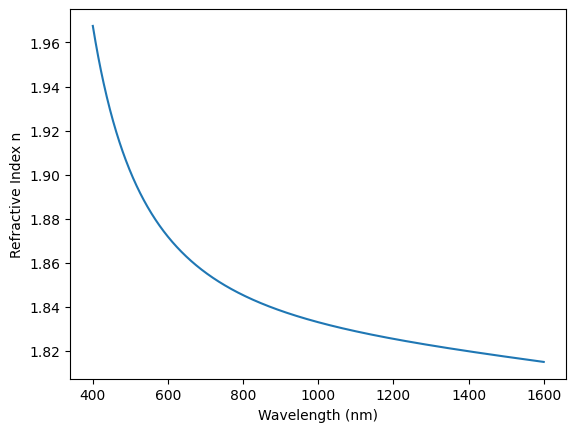

In [438]:
#Plotting refractive index as a function of wavelength
#Parameters for the Sellmeier
A = 2.12725
B = 1.18431
C = 5.14852e-2
D = 0.6603
E = 100.00507
F = 9.68956e-3
#These experimental parameters are taken from "K. Fradkin, A. Arie, A. Skliar, and G. Rosenman"
wavelengths = np.linspace(400, 1600, 1000) #Wavelengths in nm
temperature = 300  # Temperature in Kelvin
a1_list = np.array([9.9587, 9.9228, -8.9603, 4.1010])*1e-6  # Experimental values taken from S. Emanueli and A. Arie
a2_list = np.array([-1.1882 ,10.459, -9.8136, 3.1481])*1e-8  # Experimental values taken from S. Emanueli and A. Arie
n_values = refractive_index_total(temperature, A, B, C, D, E, F, a1_list, a2_list, wavelengths)
fig, ax = plt.subplots()
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Refractive Index n")
ax.plot(wavelengths, n_values)


In [439]:
temperature = np.linspace(273, 273+100, 20000)  # Temperature in Kelvin
#Frequency for 1550 nm
wavelengths = np.array([1550, 775])  # Wavelengths in nm
c = 299792458
frequencies = c / (wavelengths * 1e-9)  # Frequencies in Hz
omegas = 2 * np.pi * frequencies  # Angular frequencies in rad/s
n_value_list = []
for i in tq.tqdm(range(len(wavelengths))):
    n_values = refractive_index_total(temperature, A, B, C, D, E, F, a1_list, a2_list, np.array([wavelengths[i]]))
    n_value_list.append(n_values)
n_value_array = np.array(n_value_list)
Lambda_0 = 24.701e-6  # Poling period of the crystal in meters
T_ref = 25 + 273.15  # Reference temperature in Kelvin
a_z = 8.7e-6 #C^-1, Linear thermal expansion coefficient for KTP. Taken from Shai Emanueli and Ady Arie
QPM = quasi_phase_mismatch(n_value_array[1,:], omegas[1], n_value_array[0,:], omegas[0], Lambda_0, temperature, T_ref, a_z)
L = 405*Lambda_0
SHG_output = second_harmonic_output(QPM, L)  # Crystal length in meters, Input intensity in W/m^2

100%|██████████| 2/2 [00:00<00:00, 2034.59it/s]


For perfect edges Δr and Δl are 0 and assuming undepleted pump such that A_omega is constant


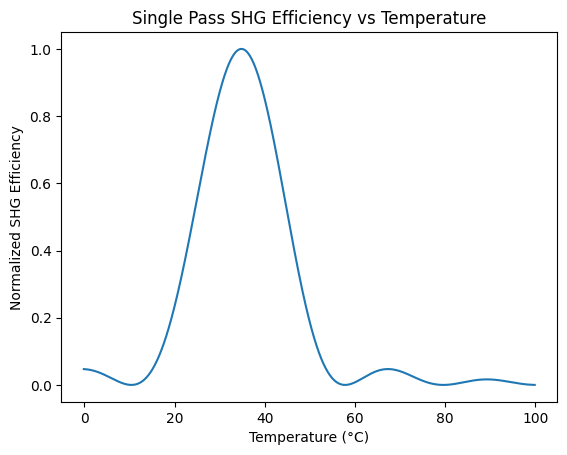

In [440]:
fig, ax = plt.subplots()
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("SHG at output (a.u.)")
ax.plot(temperature - 273.15, (SHG_output/L)**2)
ax.set_ylabel("Normalized SHG Efficiency")
ax.set_title("Single Pass SHG Efficiency vs Temperature")
# ax.set_ylim(-100, 100) # Removed to allow autoscaling
print("For perfect edges Δr and Δl are 0 and assuming undepleted pump such that A_omega is constant")
plt.show()

## Double-pass non linear interaction

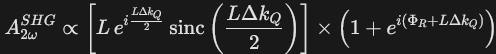

100%|██████████| 4/4 [00:00<00:00, 211.20it/s]


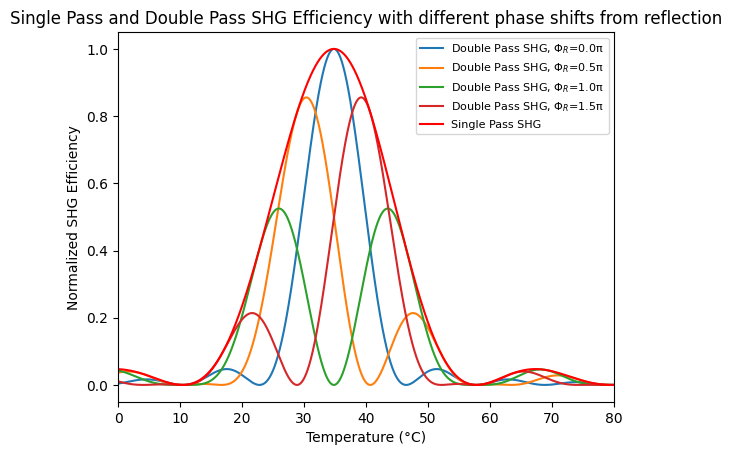

In [441]:
phi_R = np.pi*np.array([0,1/2,1,3/2])
double_pass_val = []
for i in tq.tqdm(range(len(phi_R))):
    double_pass_SHG_output = double_pass_SHG(QPM, L, phi_R[i])
    double_pass_val.append(double_pass_SHG_output)
fig, ax = plt.subplots()
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("SHG at output (a.u.)")
for i in range(len(phi_R)):
    double_pass_SHG_output = double_pass_val[i]
    ax.plot(temperature - 273.15, (double_pass_SHG_output/L)**2 /4, label=f'Double Pass SHG, $\\Phi_R$={phi_R[i]/np.pi}π')
ax.plot(temperature - 273.15, (SHG_output/L)**2, color='r', label='Single Pass SHG')
ax.set_ylabel("Normalized SHG Efficiency")
ax.set_xlim(0,80)
ax.set_title("Single Pass and Double Pass SHG Efficiency with different phase shifts from reflection")
ax.legend(prop={'size':8})

## Inside optical cavity
Mirror with has reflectivity and transmitivity of $\rho$ and $\tau$. Mirror is a distance $D$ from crystal. We now have 4 intracavity electric fields.
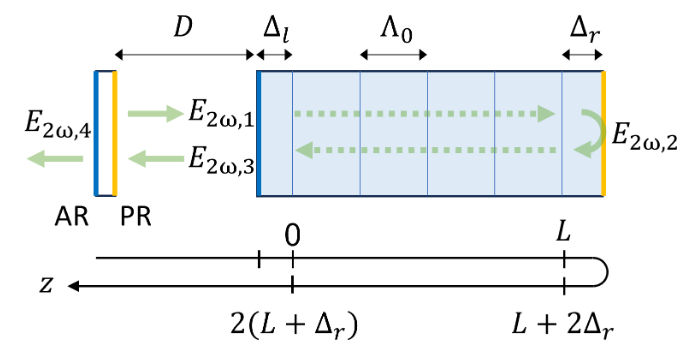


$$
E_{2\omega,1} = \rho\, E_{2\omega,3}
$$

$$
E_{2\omega,2} = e^{-i k_{2\omega} D}
\left(
E_{2\omega,1} + E^{(1)}_{2\omega} e^{-i \Delta k(T)\, \Delta r}
\right)
$$

$$
E_{2\omega,3} = e^{-i k_{2\omega} D}
\left(
E_{2\omega,2} + E^{(2)}_{2\omega} e^{-i \Delta k(T)\, \Delta l}
\right)
$$

$$
E_{2\omega,4} = i\, \tau\, E_{2\omega,3}.
$$


In [442]:
tau = 0.06 #Transmission coefficient of the output coupler
rho = (1-tau**2) #Reflection coefficient of the output coupler
Delta_r = 5e-6 #Error in the right edge of the crystal
Delta_l = 5e-6 #Error in the left edge of the crystal
D = 15e-3 #Distance from the crystal to the output coupler
exiting_field = final_cavity_field(tau, rho, QPM, L, Delta_r, Delta_l, D, n_value_array[0,:], omegas[0], n_value_array[1,:], omegas[1])
exiting_field_no_cavity = final_cavity_field(tau, 0, QPM, L, Delta_r, Delta_l, D, n_value_array[0,:], omegas[0], n_value_array[1,:], omegas[1])

Parameters: tau=0.06, rho=0.9964, Delta_r=5e-06 m, Delta_l=5e-06 m, D=0.015 m


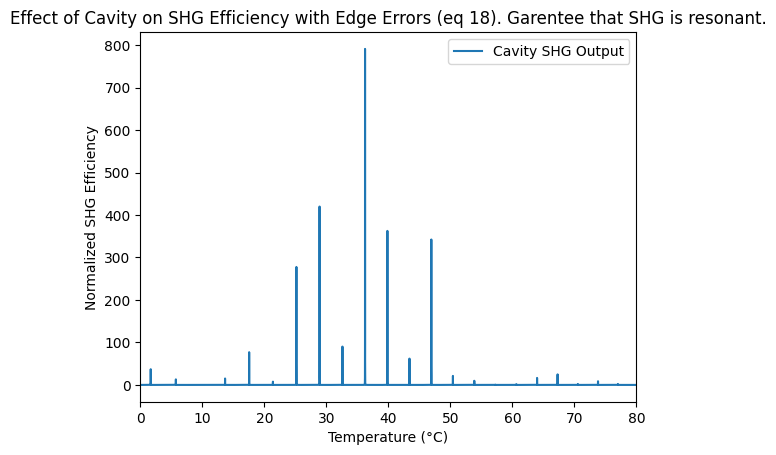

In [443]:
fig,ax = plt.subplots()
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Normalized SHG Efficiency")
ax.plot(temperature - 273.15, (np.abs(exiting_field)/L)**2, label='Cavity SHG Output')
# ax.plot(temperature - 273.15, (np.abs(exiting_field_no_cavity)/L)**2, label='No Cavity (rho=0)', linestyle='--')
ax.set_title("Effect of Cavity on SHG Efficiency with Edge Errors (eq 18). Garentee that SHG is resonant.")
ax.set_xlim(0,80)
ax.legend()
print(f"Parameters: tau={tau}, rho={rho}, Delta_r={Delta_r} m, Delta_l={Delta_l} m, D={D} m")

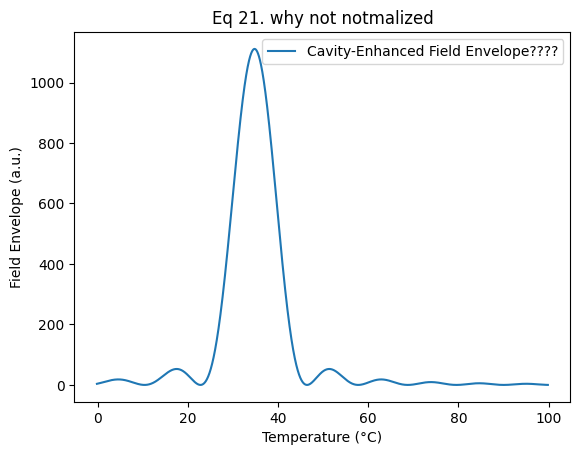

In [444]:
envelopefield = field_envelope(tau, rho, QPM, L, Delta_r, Delta_l, n_value_array[1,:], omegas[1], n_value_array[0,:], omegas[0])
fig, ax = plt.subplots()
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Field Envelope (a.u.)")
ax.plot(temperature - 273.15, np.abs(envelopefield/L)**2, label='Cavity-Enhanced Field Envelope????')
ax.set_title("Eq 21. why not notmalized")
ax.legend()

Parameters: tau=0.06, rho=0.9964, Delta_r=5e-06 m, Delta_l=5e-06 m, D=0.015 m


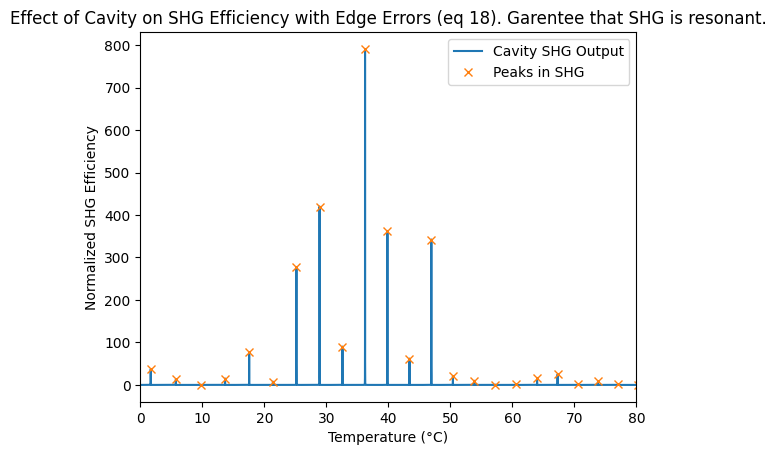

In [445]:
peaks_in_SHG, _ = find_peaks(np.abs(exiting_field)**2)
fig,ax = plt.subplots()
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Normalized SHG Efficiency")
ax.plot(temperature - 273.15, (np.abs(exiting_field)/L)**2, label='Cavity SHG Output')
# ax.plot(temperature - 273.15, (np.abs(exiting_field_no_cavity)/L)**2, label='No Cavity (rho=0)', linestyle='--')
ax.plot(temperature[peaks_in_SHG] - 273.15, (np.abs(exiting_field[peaks_in_SHG])/L)**2, 'x', label='Peaks in SHG')
ax.set_title("Effect of Cavity on SHG Efficiency with Edge Errors (eq 18). Garentee that SHG is resonant.")
ax.set_xlim(0,80)
ax.legend()
print(f"Parameters: tau={tau}, rho={rho}, Delta_r={Delta_r} m, Delta_l={Delta_l} m, D={D} m")

In [446]:
T_indi = double_resonance_temperatures(temperature, Delta_l, Delta_r, D, L, n_value_array[1,:], omegas[1], n_value_array[0,:], omegas[0], phi_l=0, phi_r=phi_R[0])
# print("Resonance temperatures (°C):", temperature[T_indi] - 273.15)
T_indi2 = temperature[peaks_in_SHG] - 273.15
# print(T_indi2)

In [447]:
# Print temperatures where relative phase condition is met
print("Phase Match Temps:", temperature[T_indi] - 273.15)

# Print temperatures where SHG is resonant (Peaks)
print("SHG Peak Temps:", temperature[peaks_in_SHG] - 273.15)


Phase Match Temps: [11.63558928 25.13126406 38.1319141  50.68754188 62.84814991 74.63873944
 86.09431222 97.24486974]
SHG Peak Temps: [ 1.670091    5.72529376  9.72049352 13.66069053 17.54588479 21.38107655
 25.16626581 28.90145257 32.59163708 36.23681934 39.8419996  43.40217761
 46.92735387 50.41252813 53.85770039 57.26787089 60.64303965 63.98320666
 67.29337217 70.56853593 73.81369818 77.02885894 80.2140182  83.36917596
 86.49933247 89.59948747 92.67464123 95.72479374 98.749945  ]


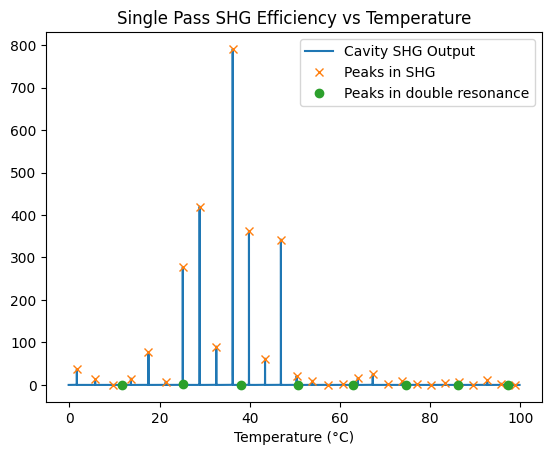

In [448]:
fig, ax = plt.subplots()
ax.set_xlabel("Temperature (°C)")
ax.plot(temperature - 273.15, (np.abs(exiting_field)/L)**2, label='Cavity SHG Output')
ax.plot(temperature[peaks_in_SHG] - 273.15, (np.abs(exiting_field[peaks_in_SHG])/L)**2, 'x', label='Peaks in SHG')
ax.plot(temperature[T_indi] - 273.15, (np.abs(exiting_field[T_indi])/L)**2, 'o', label='Peaks in double resonance')
ax.set_title("Single Pass SHG Efficiency vs Temperature")
ax.legend()

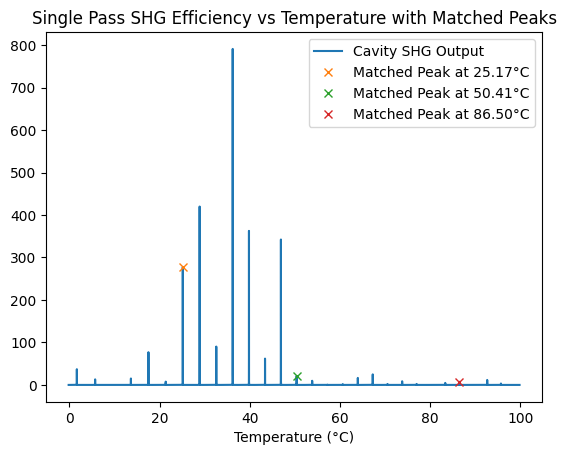

In [449]:
matched_peaks = matched_peaks(temperature, peaks_in_SHG, T_indi)
fig, ax = plt.subplots()
ax.set_xlabel("Temperature (°C)")
ax.plot(temperature - 273.15, (np.abs(exiting_field)/L)**2, label='Cavity SHG Output')
for peak_temp, res_temp in matched_peaks:
    ax.plot(peak_temp - 273.15, (np.abs(exiting_field[temperature == peak_temp])/L)**2, 'x', label=f'Matched Peak at {peak_temp - 273.15:.2f}°C')
ax.set_title("Single Pass SHG Efficiency vs Temperature with Matched Peaks")
ax.legend()

(0.0, 70.0)

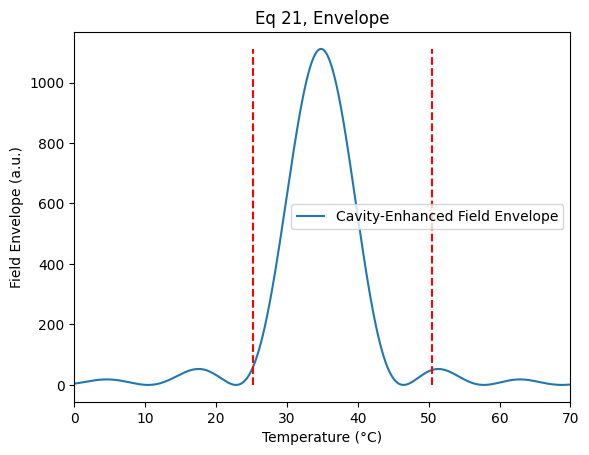

In [450]:
envelopefield = field_envelope(tau, rho, QPM, L, Delta_r, Delta_l, n_value_array[1,:], omegas[1], n_value_array[0,:], omegas[0])
fig, ax = plt.subplots()
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Field Envelope (a.u.)")
ax.plot(temperature - 273.15, np.abs(envelopefield/L)**2, label='Cavity-Enhanced Field Envelope')
ax.set_title("Eq 21, Envelope")
for peak_temp, res_temp in matched_peaks:
    ax.vlines(peak_temp - 273.15, ymin=0, ymax=np.max(np.abs(envelopefield/L)**2), colors='r', linestyles='--')
ax.legend()
ax.set_xlim(0,70)

In [451]:
phi_l = np.array([0, np.pi/2, np.pi])
phi_r = np.array([0])
envelope_list = []
T_indices_list = []
for i in phi_r:
    for j in phi_l:
        envelope, T_indices = envelope_and_T(tau, rho, QPM, L, Delta_r, Delta_l, n_value_array[1,:], omegas[1], n_value_array[0,:], omegas[0], D, temperature, phi_l=j, phi_r=i)
        envelope_list.append(envelope)
        T_indices_list.append(T_indices)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 57.06it/s]


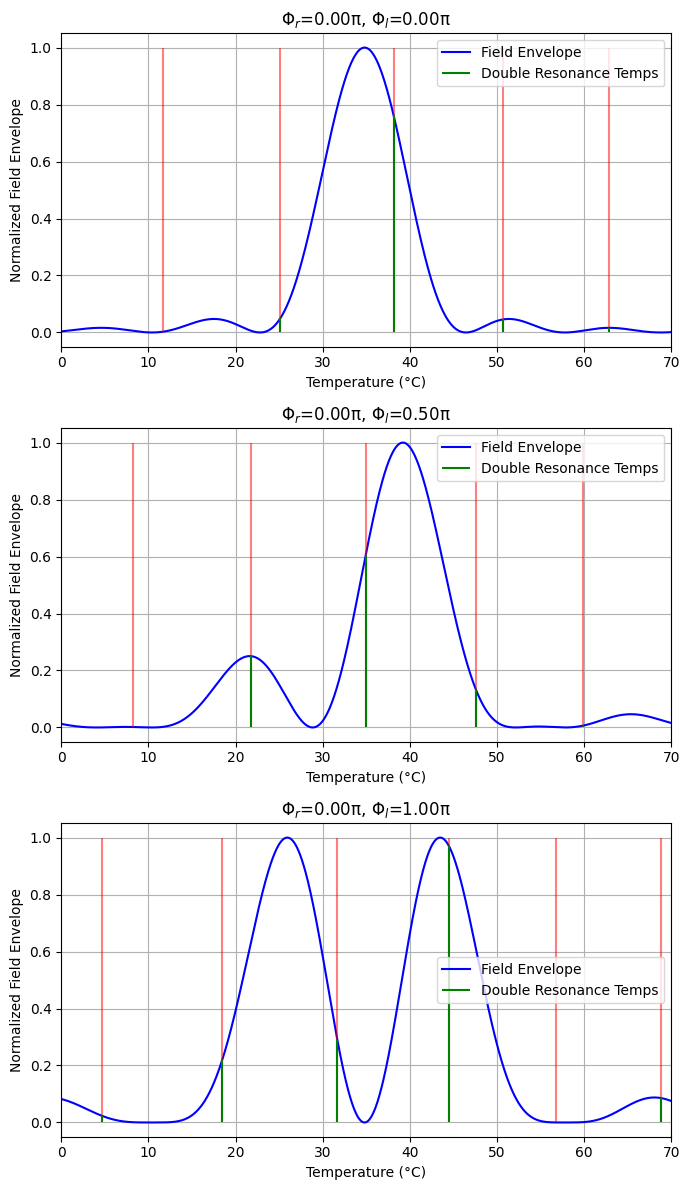

In [456]:
rows = len(phi_l)
cols = len(phi_r)
fig, ax = plt.subplots(rows, cols, figsize=(7*cols, 4*rows), squeeze=False)

for i in tq.tqdm(range(rows)):
    for j in range(cols):
        index = j * rows + i
        res_indices = T_indices_list[index]
        
        # Calculate normalized envelope values
        y_vals = np.abs(envelope_list[index]/L)**2
        max_val = np.max(y_vals) if np.max(y_vals) != 0 else 1.0
        y_norm = y_vals / max_val
        
        # Calculate envelope values only at the resonant temperatures (normalized)
        res_envelope_vals = y_norm[res_indices]
        
        ax[i,j].plot(temperature - 273.15, y_norm, label='Field Envelope', color='blue')
        # Gray line to max height (now 1.0)
        ax[i,j].vlines(temperature[res_indices] - 273.15, ymin=0, ymax=1.0, colors='red', linestyles='-', alpha=0.5)
        # Red line to envelope value
        ax[i,j].vlines(temperature[res_indices] - 273.15, ymin=0, ymax=res_envelope_vals, colors='green', linestyles='-', label='Double Resonance Temps')
        
        ax[i,j].set_title(f'$\\Phi_r$={phi_r[j]/np.pi:.2f}π, $\\Phi_l$={phi_l[i]/np.pi:.2f}π')
        ax[i,j].set_xlabel("Temperature (°C)")
        ax[i,j].set_ylabel("Normalized Field Envelope")
        ax[i,j].set_xlim(0,70)
        ax[i,j].grid()
        ax[i,j].legend()
plt.tight_layout()